# Final_Project - Loan Prediction



In [101]:
import csv
import pandas as pd
import sqlite3

def create_tables(conn):
    # SQL commands to create the necessary tables
    create_table_queries = [
        "DROP TABLE IF EXISTS Personal_Details",
        "DROP TABLE IF EXISTS Loan",
        "DROP TABLE IF EXISTS Prop_Details",
        "DROP TABLE IF EXISTS Edu_Details",
        """
        CREATE TABLE IF NOT EXISTS [Prop_Details] (
            [Prop_details_ID] INTEGER PRIMARY KEY NOT NULL,
            [Property_Area] TEXT NOT NULL
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS [Edu_Details] (
            [Edu_details_ID] INTEGER PRIMARY KEY NOT NULL,
            [Education] TEXT NOT NULL
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS [Loan] (
            [ID] INTEGER PRIMARY KEY NOT NULL,
            [Loan_ID] TEXT NOT NULL,
            [ApplicantIncome] INTEGER NOT NULL,
            [CoapplicantIncome] INTEGER NOT NULL,
            [LoanAmount] INTEGER,
            [Loan_Amount_Term] INTEGER,
            [Credit_History] INTEGER,
            [Loan_Status] TEXT NOT NULL
        );
        """,
        """
        CREATE TABLE IF NOT EXISTS [Personal_Details] (
            [Personal_details_ID] INTEGER PRIMARY KEY NOT NULL,
            [Loan_ID] TEXT NOT NULL,
            [Gender] TEXT,
            [Married] TEXT,
            [Dependents] TEXT,
            [Edu_details_ID] TEXT NOT NULL,
            [Self_Employed] TEXT,
            [Prop_details_ID] TEXT NOT NULL,
            FOREIGN KEY(Loan_ID) REFERENCES Loan(ID),
            FOREIGN KEY(Edu_details_ID) REFERENCES Edu_Details(Edu_details_ID),
            FOREIGN KEY(Prop_details_ID) REFERENCES Prop_Details(Prop_details_ID)
        );
        """
    ]

    for query in create_table_queries:
        conn.execute(query)
    conn.commit()


def insert_data(conn, table_name, columns, values):
    """
    Insert data into a table, handling duplicate entries gracefully.
    """
    insert_query = f"INSERT OR IGNORE INTO {table_name} ({', '.join(columns)}) VALUES ({', '.join(['?' for _ in columns])})"
    conn.executemany(insert_query, values)
    conn.commit()


def load_data_from_csv(file_path):
    """
    Load and preprocess the CSV data.
    """
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)[1:]

        data = [dict(zip(header, row[1:])) for row in reader]
    
    return data


def get_unique_values(df, column_name):
    """
    Extract unique values for given column from the DataFrame.
    """
    return set(row[column_name] for row in df)

def main():
    conn = sqlite3.connect("loan_requests.db")
    conn.execute("PRAGMA foreign_keys = 1;")

    create_tables(conn)

    df = load_data_from_csv('loan_prediction.csv')

    prop_values = [(area,) for area in get_unique_values(df, "Property_Area")]
    edu_values = [(edu,) for edu in get_unique_values(df, "Education")]

    loan_details_col = ['ID', 'Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Loan_Status']
    loan_details = [
        (
            idx + 1,
            row["Loan_ID"],
            int(row["ApplicantIncome"]),
            float(row["CoapplicantIncome"]),
            int(row["LoanAmount"]) if row["LoanAmount"] else None,
            int(row["Loan_Amount_Term"]) if row["Loan_Amount_Term"] else None,
            int(row["Credit_History"]) if row["Credit_History"] else None,
            row["Loan_Status"]
        )
        for idx, row in enumerate(df)
    ]

    insert_data(conn, "Prop_Details", ["Property_Area"], prop_values)
    insert_data(conn, "Edu_Details", ["Education"], edu_values)
    insert_data(conn, "Loan", loan_details_col, loan_details)


    prop_dict = {row[1]: row[0] for row in conn.execute("SELECT * FROM Prop_Details")}
    edu_dict = {row[1]: row[0] for row in conn.execute("SELECT * FROM Edu_Details")}
    loan_dict = {row[1]: row[0] for row in conn.execute("SELECT ID, Loan_ID FROM Loan")}

    personal_details = [
        (
            idx + 1,
            loan_dict[row["Loan_ID"]],
            row["Gender"] if row["Gender"] else None,
            row["Married"] if row["Married"] else None,
            row["Dependents"] if row["Dependents"] else None,
            edu_dict[row["Education"]],
            row["Self_Employed"] if row["Self_Employed"] else None,
            prop_dict[row["Property_Area"]]
        )
        for idx, row in enumerate(df)
    ]

    insert_data(conn, "Personal_Details", ['Personal_details_ID', 'Loan_ID', 'Gender', 'Married', 'Dependents', 'Edu_details_ID', 'Self_Employed', 'Prop_details_ID'], personal_details)

    select_query = """
            select l.Loan_ID, p.Gender, p.Married, p.Dependents, e.Education, p.Self_Employed, l.ApplicantIncome, l.CoapplicantIncome, l.LoanAmount, l.Loan_Amount_Term, l.Credit_History, prop.Property_Area, l.Loan_Status
            from Personal_Details as p
            inner join Loan as l on l.ID = p.Loan_ID
            inner join Edu_Details as e on e.Edu_details_ID = p.Edu_details_ID
            inner join Prop_Details as prop on prop.Prop_details_ID = p.Prop_details_ID;
        """

    result = pd.read_sql_query(select_query, conn)

    conn.close()

    return result


In [102]:
NUMERIC_FEATURES = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History"]
CATEGORICAL_FEATURES = ["Gender", "Married", "Education", "Self_Employed", "Property_Area"]


loan_app = main()
loan_app = loan_app.drop('Loan_ID', axis=1)
loan_app['Total_Income'] = loan_app['ApplicantIncome'] + loan_app['CoapplicantIncome']
loan_app['Loan_Status'] = loan_app['Loan_Status'].map({'Y': 1, 'N': 0})
loan_app[NUMERIC_FEATURES] = loan_app[NUMERIC_FEATURES].astype(float)


loan_app.head(5)

Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
0   Male      No          0      Graduate            No           5849.0   
1   Male     Yes          1      Graduate            No           4583.0   
2   Male     Yes          0      Graduate           Yes           3000.0   
3   Male     Yes          0  Not Graduate            No           2583.0   
4   Male      No          0      Graduate            No           6000.0   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                0.0         NaN             360.0             1.0   
1             1508.0       128.0             360.0             1.0   
2                0.0        66.0             360.0             1.0   
3             2358.0       120.0             360.0             1.0   
4                0.0       141.0             360.0             1.0   

  Property_Area  Loan_Status  Total_Income  
0         Urban            1        5849.0  
1         Rural            0        6091.0  
2         Urban            1        3000.0  
3         Urban            1        4941.0  
4         Urban            1        6000.0

In [103]:
from ydata_profiling import ProfileReport

profile = ProfileReport(loan_app, title="Yprofile Report")
profile.to_file("my_data_profile_report.html")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

There is a lot more that you can do with outputs (such as including interactive outputs)
with your book. For more information about this, see [the Jupyter Book documentation](https://jupyterbook.org)

<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

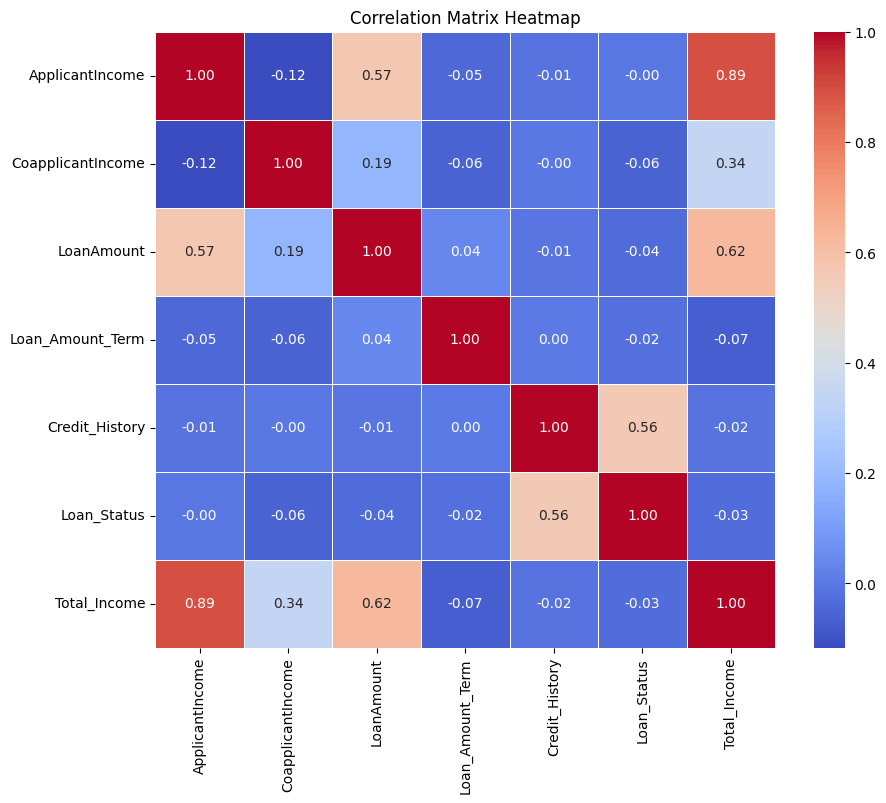

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

numerical_columns = loan_app.select_dtypes(include=['number'])

# Compute the correlation matrix for numerical columns
correlation_matrix = numerical_columns.corr()

plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")

In [106]:
import os
import mlflow
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import FunctionTransformer, Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from mlflow.models import infer_signature

f1_scores_all_models = []

loan_app[NUMERIC_FEATURES] = loan_app[NUMERIC_FEATURES].astype(float)
loan_app["Credit_History"] = loan_app["Credit_History"].fillna(2.0)
loan_app["Credit_History_Cat"] = pd.cut(
    loan_app["Credit_History"], 
    bins=[-np.inf, 0, 1, 2], 
    labels=[1, 2, 3]
)

strat_train_set, strat_test_set = train_test_split(
    loan_app, test_size=0.20, stratify=loan_app["Credit_History_Cat"], random_state=42
)

for set_ in (strat_train_set, strat_test_set):
    set_.drop("Credit_History_Cat", axis=1, inplace=True)

X_train = strat_train_set.drop("Loan_Status", axis=1)
y_train = strat_train_set["Loan_Status"].copy()
X_test = strat_test_set.drop("Loan_Status", axis=1)
y_test = strat_test_set["Loan_Status"].copy()

NUMERIC_FEATURES_FE = NUMERIC_FEATURES + ["Total_Income"]


numeric_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log1p),
    StandardScaler(),
    MinMaxScaler()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = Pipeline([
    ('col_transform', ColumnTransformer(
        [
            ("num", numeric_pipeline, NUMERIC_FEATURES_FE),
            ("cat", categorical_pipeline, CATEGORICAL_FEATURES)
        ],
        remainder='drop'  # ensure no leftover columns with NaNs
    ))
])

logistic_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('clf', LogisticRegression(solver='liblinear', random_state=42))
])
param_grid = {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__solver': ['liblinear', 'lbfgs']
}

f1_scorer = make_scorer(f1_score)

#dagshub.init(repo_owner='srujanavirneni', repo_name='Loan_prediction', mlflow=True)

mlflow.set_tracking_uri("https://dagshub.com/srujanavirneni/Loan_prediction.mlflow")
os.environ['MLFLOW_TRACKING_USERNAME']='srujanavirneni'
os.environ['MLFLOW_TRACKING_PASSWORD']='711d133c089a37afdab1303e8163bf703c394673'
mlflow.set_experiment("Experiment_1")

grid_search = GridSearchCV(logistic_pipeline, param_grid, cv=3, scoring=f1_scorer, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Train on the whole training set with the best model
y_pred_train = best_model.predict(X_train)
f1_train = f1_score(y_train, y_pred_train)
cm_train = confusion_matrix(y_train, y_pred_train)

y_pred_test = best_model.predict(X_test)
f1_test = f1_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

f1_scores_all_models.append({'Logistic Regression': f1_test})

# Evaluate using cross-validation (3-fold as already used in GridSearch, and also 10-fold for demonstration)
cv_scores_3 = cross_val_score(best_model, X_train, y_train, cv=3, scoring=f1_scorer)
cv_scores_10 = cross_val_score(best_model, X_train, y_train, cv=10, scoring=f1_scorer)

with mlflow.start_run():
    # Log parameters
    mlflow.log_params(grid_search.best_params_)
    
    # Log metrics
    mlflow.log_metric("f1_train", f1_train)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("cv_f1_mean_3fold", np.mean(cv_scores_3))
    mlflow.log_metric("cv_f1_std_3fold", np.std(cv_scores_3))
    mlflow.log_metric("cv_f1_mean_10fold", np.mean(cv_scores_10))
    mlflow.log_metric("cv_f1_std_10fold", np.std(cv_scores_10))
    
    # Log confusion matrix data as artifacts or as parameters (for simplicity, just print or store)
    # Typically you'd store the CM as a figure or in a CSV artifact.
    cm_train_str = np.array2string(cm_train)
    cm_test_str = np.array2string(cm_test)
    
    # Log artifacts: You can log a small text file with confusion matrix
    with open("cm_train.txt", "w") as f:
        f.write(cm_train_str)
    with open("cm_test.txt", "w") as f:
        f.write(cm_test_str)
        
    mlflow.log_artifact("cm_train.txt")
    mlflow.log_artifact("cm_test.txt")
    
    # Infer model signature
    signature = infer_signature(X_train, best_model.predict(X_train))

    # Log the model
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="LogisticRegression",
        signature=signature,
        registered_model_name="LogisticRegression"
    )




<Experiment: artifact_location='mlflow-artifacts:/ea73c220c2dc4c1f9b804e2c2b3fdda8', creation_time=1734714831999, experiment_id='0', last_update_time=1734714831999, lifecycle_stage='active', name='Experiment_1', tags={}>

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END .................clf__C=0.01, clf__solver=liblinear; total time=   0.0s
[CV] END .................clf__C=0.01, clf__solver=liblinear; total time=   0.0s
[CV] END .................clf__C=0.01, clf__solver=liblinear; total time=   0.0s
[CV] END .....................clf__C=0.01, clf__solver=lbfgs; total time=   0.0s
[CV] END ..................clf__C=0.1, clf__solver=liblinear; total time=   0.0s
[CV] END ......................clf__C=0.1, clf__solver=lbfgs; total time=   0.0s
[CV] END .....................clf__C=0.01, clf__solver=lbfgs; total time=   0.0s
[CV] END ..................clf__C=0.1, clf__solver=liblinear; total time=   0.0s
[CV] END .....................clf__C=0.01, clf__solver=lbfgs; total time=   0.1s
[CV] END ......................clf__C=0.1, clf__solver=lbfgs; total time=   0.0s
[CV] END ....................clf__C=1, clf__solver=liblinear; total time=   0.0s
[CV] END ....................clf__C=1, clf__solve

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('col_transform',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('simpleimputer',
                                                                                                           SimpleImputer(strategy='median')),
                                                                                                          ('functiontransformer',
                                                                                                           FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                          ('standardscaler',
                                                                                                           StandardScaler()),
                                                                                                          ('minmaxscaler',
                                                                                                           MinMaxScaler())]),
                                                                                          ['ApplicantInco...
                                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                                          ('onehotencoder',
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['Gender',
                                                                                           'Married',
                                                                                           'Education',
                                                                                           'Self_Employed',
                                                                                           'Property_Area'])]))])),
                                       ('clf',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10],
                         'clf__solver': ['liblinear', 'lbfgs']},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=2)

22

18

Registered model 'LogisticRegression' already exists. Creating a new version of this model...
2024/12/20 11:17:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 12
Created version '12' of model 'LogisticRegression'.


🏃 View run glamorous-ram-382 at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/0/runs/a331f8d7213e4bea880dd0f9cbe39aa3
🧪 View experiment at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/0


In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier


classifiers = {
    "LogisticRegression": (
        LogisticRegression(max_iter=1000, random_state=42),
        {
            'logisticregression__C': [0.01, 0.1, 1, 10],
            'logisticregression__solver': ['lbfgs', 'liblinear']
        }
    ),
    "RidgeClassifier": (
        RidgeClassifier(random_state=42),
        {
            'ridgeclassifier__alpha': [0.1, 1.0, 10.0]
        }
    ),
    "RandomForestClassifier": (
        RandomForestClassifier(random_state=42),
        {
            'randomforestclassifier__n_estimators': [100, 200],
            'randomforestclassifier__max_depth': [None, 10, 20]
        }
    ),
    "XGBClassifier": (
        XGBClassifier(eval_metric='logloss', random_state=42),
        {
            'xgbclassifier__n_estimators': [100, 200],
            'xgbclassifier__max_depth': [3, 6],
            'xgbclassifier__learning_rate': [0.01, 0.1, 0.3]
        }
    )
}

mlflow.set_experiment("Experiment_2")

for clf_name, (clf, param_grid) in classifiers.items():
    model_pipeline = make_pipeline(
        preprocessing, clf
    )

    grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, scoring=f1_scorer, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # Train on the whole training set with the best model
    y_pred_train = best_model.predict(X_train)
    f1_train = f1_score(y_train, y_pred_train)

    y_pred_test = best_model.predict(X_test)
    f1_test = f1_score(y_test, y_pred_test)

    f1_scores_all_models.append({clf_name: f1_test})

    with mlflow.start_run(run_name=clf_name):
        # Log parameters
        mlflow.log_params(grid_search.best_params_)

        # Log metrics
        mlflow.log_metric("f1_train", f1_train)
        mlflow.log_metric("f1_test", f1_test)

        # Infer model signature
        signature = infer_signature(X_train, best_model.predict(X_train))

        # Log the model
        mlflow.sklearn.log_model(
            sk_model=best_model,
            artifact_path=clf_name,
            signature=signature,
            registered_model_name=clf_name
        )

<Experiment: artifact_location='mlflow-artifacts:/70210216175744fea39479b5b78ecc4c', creation_time=1734718206692, experiment_id='2', last_update_time=1734718206692, lifecycle_stage='active', name='Experiment_2', tags={}>

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END logisticregression__C=0.01, logisticregression__solver=lbfgs; total time=   0.0s
[CV] END logisticregression__C=0.01, logisticregression__solver=lbfgs; total time=   0.0s
[CV] END logisticregression__C=0.01, logisticregression__solver=lbfgs; total time=   0.0s
[CV] END logisticregression__C=0.01, logisticregression__solver=liblinear; total time=   0.0s
[CV] END logisticregression__C=0.01, logisticregression__solver=liblinear; total time=   0.0s
[CV] END logisticregression__C=0.01, logisticregression__solver=liblinear; total time=   0.0s
[CV] END logisticregression__C=0.1, logisticregression__solver=lbfgs; total time=   0.0s
[CV] END logisticregression__C=0.1, logisticregression__solver=lbfgs; total time=   0.0s
[CV] END logisticregression__C=0.1, logisticregression__solver=liblinear; total time=   0.0s
[CV] END logisticregression__C=0.1, logisticregression__solver=lbfgs; total time=   0.0s
[CV] END logisticregression_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('col_transform',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('simpleimputer',
                                                                                                           SimpleImputer(strategy='median')),
                                                                                                          ('functiontransformer',
                                                                                                           FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                          ('standardscaler',
                                                                                                           StandardScaler()),
                                                                                                          ('minmaxscaler',
                                                                                                           MinMaxScaler())]),
                                                                                          ['ApplicantIncome',
                                                                                           '...
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['Gender',
                                                                                           'Married',
                                                                                           'Education',
                                                                                           'Self_Employed',
                                                                                           'Property_Area'])]))])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10],
                         'logisticregression__solver': ['lbfgs', 'liblinear']},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=2)

Registered model 'LogisticRegression' already exists. Creating a new version of this model...
2024/12/20 11:17:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 13
Created version '13' of model 'LogisticRegression'.


🏃 View run LogisticRegression at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/2/runs/6dd8667eb1bb47d5bad01567f6278b4b
🧪 View experiment at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/2
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END .........................ridgeclassifier__alpha=0.1; total time=   0.0s
[CV] END .........................ridgeclassifier__alpha=0.1; total time=   0.0s
[CV] END .........................ridgeclassifier__alpha=0.1; total time=   0.0s
[CV] END .........................ridgeclassifier__alpha=1.0; total time=   0.0s
[CV] END .........................ridgeclassifier__alpha=1.0; total time=   0.0s
[CV] END .........................ridgeclassifier__alpha=1.0; total time=   0.0s
[CV] END ........................ridgeclassifier__alpha=10.0; total time=   0.0s
[CV] END ........................ridgeclassifier__alpha=10.0; total time=   0.0s
[CV] END ........................ridgeclassifier__a

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('col_transform',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('simpleimputer',
                                                                                                           SimpleImputer(strategy='median')),
                                                                                                          ('functiontransformer',
                                                                                                           FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                          ('standardscaler',
                                                                                                           StandardScaler()),
                                                                                                          ('minmaxscaler',
                                                                                                           MinMaxScaler())]),
                                                                                          ['ApplicantIncome',
                                                                                           '...
                                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                                          ('onehotencoder',
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['Gender',
                                                                                           'Married',
                                                                                           'Education',
                                                                                           'Self_Employed',
                                                                                           'Property_Area'])]))])),
                                       ('ridgeclassifier',
                                        RidgeClassifier(random_state=42))]),
             n_jobs=-1, param_grid={'ridgeclassifier__alpha': [0.1, 1.0, 10.0]},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=2)

Registered model 'RidgeClassifier' already exists. Creating a new version of this model...
2024/12/20 11:17:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RidgeClassifier, version 5
Created version '5' of model 'RidgeClassifier'.


🏃 View run RidgeClassifier at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/2/runs/6f4f034d379049df8b7cd4fcb5067467
🧪 View experiment at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/2
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END randomforestclassifier__max_depth=None, randomforestclassifier__n_estimators=100; total time=   0.1s
[CV] END randomforestclassifier__max_depth=None, randomforestclassifier__n_estimators=100; total time=   0.1s
[CV] END randomforestclassifier__max_depth=None, randomforestclassifier__n_estimators=100; total time=   0.1s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__n_estimators=100; total time=   0.1s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__n_estimators=100; total time=   0.1s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__n_estimators=100; total time=   0.1s
[CV] END randomforestclassifier__max_depth=None

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('col_transform',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('simpleimputer',
                                                                                                           SimpleImputer(strategy='median')),
                                                                                                          ('functiontransformer',
                                                                                                           FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                          ('standardscaler',
                                                                                                           StandardScaler()),
                                                                                                          ('minmaxscaler',
                                                                                                           MinMaxScaler())]),
                                                                                          ['ApplicantIncome',
                                                                                           '...
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['Gender',
                                                                                           'Married',
                                                                                           'Education',
                                                                                           'Self_Employed',
                                                                                           'Property_Area'])]))])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [None, 10, 20],
                         'randomforestclassifier__n_estimators': [100, 200]},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=2)

Registered model 'RandomForestClassifier' already exists. Creating a new version of this model...
2024/12/20 11:18:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestClassifier, version 5
Created version '5' of model 'RandomForestClassifier'.


🏃 View run RandomForestClassifier at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/2/runs/eefc462abfc540339c6e64832b08e27a
🧪 View experiment at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/2
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100; total time=   0.0s
[CV] END xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100; total time=   0.0s
[CV] END xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100; total time=   0.0s
[CV] END xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=200; total time=   0.1s
[CV] END xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=200; total time=   0.1s
[CV] END xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=3, x

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('col_transform',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('simpleimputer',
                                                                                                           SimpleImputer(strategy='median')),
                                                                                                          ('functiontransformer',
                                                                                                           FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                          ('standardscaler',
                                                                                                           StandardScaler()),
                                                                                                          ('minmaxscaler',
                                                                                                           MinMaxScaler())]),
                                                                                          ['ApplicantIncome',
                                                                                           '...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__learning_rate': [0.01, 0.1, 0.3],
                         'xgbclassifier__max_depth': [3, 6],
                         'xgbclassifier__n_estimators': [100, 200]},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=2)

Registered model 'XGBClassifier' already exists. Creating a new version of this model...
2024/12/20 11:18:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier, version 5
Created version '5' of model 'XGBClassifier'.


🏃 View run XGBClassifier at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/2/runs/b692aad34eb34681bef40d02aa177600
🧪 View experiment at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/2


In [108]:
loan_app = main()
loan_app['Total_Income'] = loan_app['ApplicantIncome'] + loan_app['CoapplicantIncome']
def feature_engineering(df):
    df = df.copy()
    
    # Create Total_Income
    df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
    
    # Create Has_Coapplicant indicator
    df['Has_Coapplicant'] = (df['CoapplicantIncome'] > 0).astype(int)
    
    # Create EMI - ensure Loan_Amount_Term and LoanAmount are consistent
    # For example, if Loan_Amount_Term is in months and LoanAmount in thousands,
    # consider converting them to a consistent unit.
    # Assume LoanAmount is total loan amount and Loan_Amount_Term is in months:
    # Protect against division by zero:
    df['EMI'] = np.where(df['Loan_Amount_Term'] > 0, 
                         df['LoanAmount'] / df['Loan_Amount_Term'], 0)
    
    # Drop original incomes if we consider them redundant
    df.drop(['ApplicantIncome', 'CoapplicantIncome'], axis=1, inplace=True)
    
    return df

df_fe = feature_engineering(loan_app)

numeric_features = ["LoanAmount", "Loan_Amount_Term", "Credit_History", "Total_Income", "EMI"]
categorical_features = ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area", "Has_Coapplicant"]

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log1p)),  # Named this step
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessing = Pipeline([
    ('col_transform', ColumnTransformer(
        [
            ("num", numeric_pipeline, numeric_features),
            ("cat", categorical_pipeline, categorical_features)
        ],
        remainder='drop'
    ))
])

model_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])
mlflow.set_experiment("Experiment_3")
df_fe["Loan_Status"] = df_fe["Loan_Status"].map({'Y': 1, 'N': 0})
X = df_fe.drop("Loan_Status", axis=1)
y = df_fe["Loan_Status"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred)

with mlflow.start_run(run_name="Feature_Engineering"):
        # Log parameters
        mlflow.log_params({"test_size": 0.2, "random_state": 42})

        # Log metrics
        mlflow.log_metric("f1_train", f1_train)

        # Infer model signature
        signature = infer_signature(X_train, model_pipeline.fit(X_train, y_train))

        # Log the model
        mlflow.sklearn.log_model(
            sk_model=model_pipeline,
            artifact_path="LogisticRegression",
            signature=signature,
            registered_model_name="LogisticRegression"
        )


<Experiment: artifact_location='mlflow-artifacts:/0ce1bf4fef344f99974dcd38f1f79ded', creation_time=1734716984841, experiment_id='1', last_update_time=1734716984841, lifecycle_stage='active', name='Experiment_3', tags={}>

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('col_transform',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('log',
                                                                                    FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['LoanAmount',
                                                                    'Loan_Amount_Term',
                                                                    'Credit_History',
                                                                    'Total_Income',
                                                                    'EMI']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ohe',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Gender',
                                                                    'Married',
                                                                    'Dependents',
                                                                    'Education',
                                                                    'Self_Employed',
                                                                    'Property_Area',
                                                                    'Has_Coapplicant'])]))])),
                ('clf', LogisticRegression(max_iter=1000, random_state=42))])

/opt/anaconda3/envs/loan_approval/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/12/20 11:19:05 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
Registered model

🏃 View run Feature_Engineering at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/1/runs/4fed5f7a1d104bf88ed614f8377898e9
🧪 View experiment at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/1


In [109]:
import dagshub
import pandas as pd
import numpy as np
import mlflow
from mlflow.models import infer_signature
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

class CorrelationThreshold(BaseEstimator, TransformerMixin):
    """Remove features that have a correlation above a given threshold."""
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.features_to_drop_ = None

    def fit(self, X, y=None):
        corr_matrix = np.corrcoef(X, rowvar=False)
        to_drop = set()
        rows, cols = np.where(np.abs(corr_matrix) > self.threshold)
        for i, j in zip(rows, cols):
            if i < j:
                to_drop.add(j)
        self.features_to_drop_ = list(to_drop)
        return self

    def transform(self, X):
        if self.features_to_drop_:
            return np.delete(X, self.features_to_drop_, axis=1)
        return X

# Load data
loan_app = main()
loan_app = loan_app.drop('Loan_ID', axis=1)
loan_app['Loan_Status'] = loan_app['Loan_Status'].map({'Y': 1, 'N': 0})

NUMERIC_FEATURES = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History"]
CATEGORICAL_FEATURES = ["Gender", "Married", "Education", "Self_Employed", "Property_Area"]

loan_app[NUMERIC_FEATURES] = loan_app[NUMERIC_FEATURES].astype(float)

X = loan_app.drop("Loan_Status", axis=1)
y = loan_app["Loan_Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
    ('num', numeric_pipeline, NUMERIC_FEATURES),
    ('cat', categorical_pipeline, CATEGORICAL_FEATURES)
])

feature_selection_pipeline = make_pipeline(
    VarianceThreshold(threshold=0.1),
    CorrelationThreshold(threshold=0.9),
    SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold="median")
)

model_pipeline = make_pipeline(
    preprocessing,
    feature_selection_pipeline,
    LogisticRegression(max_iter=1000, random_state=42)
)

mlflow.set_experiment("Feature_Selection_Experiment_makepipeline")

with mlflow.start_run(run_name="Feature_Selection"):
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)

    # Compute metrics
    test_f1 = f1_score(y_test, y_pred)

    # Log parameters & metrics to MLflow
    mlflow.log_param("variance_threshold", 0.1)
    mlflow.log_param("correlation_threshold", 0.9)
    mlflow.log_param("select_model", "RandomForestClassifier with median threshold")

    mlflow.log_metric("f1_test", test_f1)
    f1_scores_all_models.append({'LogisticRegressionModel_with_FS': test_f1})

    # Infer model signature
    signature = infer_signature(X_train, model_pipeline.predict(X_train))
    mlflow.sklearn.log_model(
        sk_model=model_pipeline,
        artifact_path="LogisticRegressionModel_with_FS",
        signature=signature,
        registered_model_name="LogisticRegression_with_FS"
    )

    print("F1 Score:", test_f1)


<Experiment: artifact_location='mlflow-artifacts:/3cbf0a2f5623487eb50b8d68382b4050', creation_time=1734719920135, experiment_id='3', last_update_time=1734719920135, lifecycle_stage='active', name='Feature_Selection_Experiment_makepipeline', tags={}>

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'Credit_History']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')...
                                                   'Education', 'Self_Employed',
                                                   'Property_Area'])])),
                ('pipeline',
                 Pipeline(steps=[('variancethreshold',
                                  VarianceThreshold(threshold=0.1)),
                                 ('correlationthreshold',
                                  CorrelationThreshold()),
                                 ('selectfrommodel',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='median'))])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

0.1

0.9

'RandomForestClassifier with median threshold'

Registered model 'LogisticRegression_with_FS' already exists. Creating a new version of this model...
2024/12/20 11:19:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression_with_FS, version 3
Created version '3' of model 'LogisticRegression_with_FS'.


F1 Score: 0.8586956521739131
🏃 View run Feature_Selection at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/3/runs/454080c2790840fdbad5d3a4d8fa4eaa
🧪 View experiment at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/3


In [110]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix


numeric_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

loan_app = main()
loan_app = loan_app.drop('Loan_ID', axis=1)
loan_app['Loan_Status'] = loan_app['Loan_Status'].map({'Y': 1, 'N': 0})

NUMERIC_FEATURES = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History"]
CATEGORICAL_FEATURES = ["Gender", "Married", "Education", "Self_Employed", "Property_Area"]

loan_app[NUMERIC_FEATURES] = loan_app[NUMERIC_FEATURES].astype(float)

X = loan_app.drop("Loan_Status", axis=1)
y = loan_app["Loan_Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessing = ColumnTransformer([
    ('num', numeric_pipeline, NUMERIC_FEATURES),
    ('cat', categorical_pipeline, CATEGORICAL_FEATURES)
])

# Fit preprocessing
X_train_preprocessed = preprocessing.fit_transform(X_train)
X_test_preprocessed = preprocessing.transform(X_test)

# Apply PCA to determine the number of components
pca = PCA()
pca.fit(X_train_preprocessed)
explained_variance_ratios = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratios)

# Determine number of components: for example, choose enough to explain 95% variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# Create Scree Plot
plt.figure(figsize=(10,6))
plt.plot(range(1, len(explained_variance_ratios)+1), explained_variance_ratios, 'o-', label='Individual explained variance')
plt.plot(range(1, len(explained_variance_ratios)+1), cumulative_variance, 's--', label='Cumulative explained variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance threshold')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend()
plt.tight_layout()
plt.savefig("scree_plot.png")
plt.close()

# Fit PCA with chosen n_components
pca_final = PCA(n_components=n_components)
X_train_pca = pca_final.fit_transform(X_train_preprocessed)
X_test_pca = pca_final.transform(X_test_preprocessed)

# Train a model on the selected principal components
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_pca, y_train)

y_pred = model.predict(X_test_pca)
test_f1 = f1_score(y_test, y_pred)
f1_scores_all_models.append({'PCA': test_f1})

# Logging results in MLflow
mlflow.set_experiment("PCA_Experiment - Experiment_5")
with mlflow.start_run(run_name="PCA_Dimensionality_Reduction"):
    # Log parameters
    mlflow.log_param("n_components", n_components)

    # Log metrics
    mlflow.log_metric("f1_test", test_f1)
    mlflow.log_metric("f1_train", f1_train)

    # Log scree plot
    mlflow.log_artifact("scree_plot.png")

    # Infer model signature
    signature = infer_signature(X_train_pca, model.predict(X_train_pca))

    # Log the model
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="PCA_LogisticRegression_Model",
        signature=signature,
        registered_model_name="PCA_LogReg_Model"
    )

    print("F1 Score:", test_f1)
    print("Number of PCA Components Selected:", n_components)


PCA()

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Principal Component')

Text(0, 0.5, 'Explained Variance Ratio')

Text(0.5, 1.0, 'Scree Plot')

LogisticRegression(max_iter=1000, random_state=42)

<Experiment: artifact_location='mlflow-artifacts:/e1eecffa1752445d84a61b86cb8c7531', creation_time=1734720431229, experiment_id='4', last_update_time=1734720431229, lifecycle_stage='active', name='PCA_Experiment - Experiment_5', tags={}>

np.int64(10)

Registered model 'PCA_LogReg_Model' already exists. Creating a new version of this model...
2024/12/20 11:20:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PCA_LogReg_Model, version 2
Created version '2' of model 'PCA_LogReg_Model'.


F1 Score: 0.8586956521739131
Number of PCA Components Selected: 10
🏃 View run PCA_Dimensionality_Reduction at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/4/runs/a8df887edad84c60a5fb10618a96a382
🧪 View experiment at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/4


In [112]:
from sklearn.svm import SVC


svm_model = SVC(C=1.0, kernel='rbf', random_state=42)
svm_model.fit(X_train_pca, y_train)

y_pred_svm = svm_model.predict(X_test_pca)
test_f1_svm = f1_score(y_test, y_pred_svm)
cm_svm = confusion_matrix(y_test, y_pred_svm)

mlflow.set_experiment("Custom_Experiment_1")
with mlflow.start_run(run_name="SVM_with_PCA"):
    mlflow.log_param("model_type", "SVM")
    mlflow.log_param("C", 1.0)
    mlflow.log_param("kernel", "rbf")
    mlflow.log_param("n_components", n_components)  # Assuming you've chosen PCA components before

    # Log metrics
    mlflow.log_metric("f1_test", test_f1_svm)
    f1_scores_all_models.append({'test_f1_svm': test_f1_svm})

    # Infer signature
    signature_svm = infer_signature(X_train_pca, svm_model.predict(X_train_pca))

    # Log the model
    mlflow.sklearn.log_model(
        sk_model=svm_model,
        artifact_path="SVM_Model_PCA",
        signature=signature_svm,
        registered_model_name="SVM_Model_PCA"
    )

    print("Custom Experiment 1 - SVM Model F1 Score:", test_f1_svm)
    print("N Components (PCA):", n_components)


SVC(random_state=42)

<Experiment: artifact_location='mlflow-artifacts:/3ee38cfeff964591b688a13ba989515c', creation_time=1734721139357, experiment_id='6', last_update_time=1734721139357, lifecycle_stage='active', name='Custom_Experiment_1', tags={}>

'SVM'

1.0

'rbf'

np.int64(10)

Registered model 'SVM_Model_PCA' already exists. Creating a new version of this model...
2024/12/20 11:21:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SVM_Model_PCA, version 4
Created version '4' of model 'SVM_Model_PCA'.


Custom Experiment 1 - SVM Model F1 Score: 0.8461538461538461
N Components (PCA): 10
🏃 View run SVM_with_PCA at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/6/runs/ccf53552fcfd451a9e91126ab7668c4c
🧪 View experiment at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/6


In [113]:
from sklearn.ensemble import GradientBoostingClassifier


gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_pca, y_train)

y_pred_gb = gb_model.predict(X_test_pca)
test_f1_gb = f1_score(y_test, y_pred_gb)
cm_gb = confusion_matrix(y_test, y_pred_gb)

mlflow.set_experiment("Custom_Experiment_2")
with mlflow.start_run(run_name="GradientBoosting_with_PCA"):
    mlflow.log_param("model_type", "GradientBoosting")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("max_depth", 3)
    mlflow.log_param("n_components", n_components)  # Reuse PCA components

    # Log metrics
    mlflow.log_metric("f1_test", test_f1_gb)
    f1_scores_all_models.append({'test_f1_gb': test_f1_gb})

    # Infer signature
    signature_gb = infer_signature(X_train_pca, gb_model.predict(X_train_pca))

    # Log the model
    mlflow.sklearn.log_model(
        sk_model=gb_model,
        artifact_path="GradientBoosting_Model_PCA",
        signature=signature_gb,
        registered_model_name="GradientBoosting_Model_PCA"
    )

    print("Custom Experiment 2 - Gradient Boosting Model F1 Score:", test_f1_gb)
    print("N Components (PCA):", n_components)

GradientBoostingClassifier(random_state=42)

<Experiment: artifact_location='mlflow-artifacts:/6c940a04fd834060893168d39d0c2a3f', creation_time=1734721220932, experiment_id='7', last_update_time=1734721220932, lifecycle_stage='active', name='Custom_Experiment_2', tags={}>

'GradientBoosting'

100

0.1

3

np.int64(10)

Registered model 'GradientBoosting_Model_PCA' already exists. Creating a new version of this model...
2024/12/20 11:21:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GradientBoosting_Model_PCA, version 2
Created version '2' of model 'GradientBoosting_Model_PCA'.


Custom Experiment 2 - Gradient Boosting Model F1 Score: 0.8409090909090909
N Components (PCA): 10
🏃 View run GradientBoosting_with_PCA at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/7/runs/ed92705fd81b483299ef00ca7c02e9f6
🧪 View experiment at: https://dagshub.com/srujanavirneni/Loan_prediction.mlflow/#/experiments/7


In [115]:
best_entry = max(f1_scores_all_models, key=lambda d: list(d.values())[0])

# Extract the model name and float value
model_name, model_value = list(best_entry.items())[0]

print("Model with max value:", model_name)
print("Max value:", model_value)

Model with max value: RidgeClassifier
Max value: 0.8900523560209425
